In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# inspect for tables name
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# get the name of the columns and their type
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# get the first row of your data in Measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f09aa26f08>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [14]:
# get the first row of your data in Station
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f09aa4b188>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'latitude': 21.2716}

In [15]:
# find the last date to determine the last 12 months
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= '2016-08-23').order_by(Measurement.date.desc()).all()
#print(results)

C:\Users\Irisi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


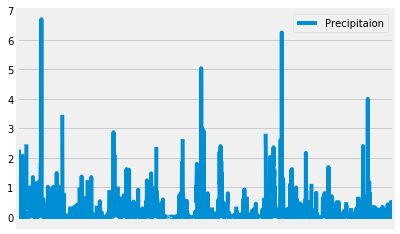

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

df_precipitation = pd.DataFrame(results, columns=['date', 'prcp'])
df_precipitation.set_index('date', inplace=True)
df_precipitation= df_precipitation.sort_index()
#plt.plot(df.date, df.prcp)

#df.plot(rot=90)
#plt.axis('off')
df_precipitation.plot()
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
ax1.legend(["Precipitaion"])
plt.savefig('Images/Precipitation.png')
plt.show()



In [18]:
# Use Pandas to print the summary statistics for the precipitation data

df_precipitation.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [19]:
# Design a query to calculate the total number of stations.
session.query(func.count(Station.station)).all()

[(9)]

In [20]:
# Design a query to find the most active stations.
# List the stations and observation counts in descending order.

stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by (Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Which station has the highest number of observations?

stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by (Measurement.station).order_by(func.count(Measurement.station).desc()).first()
stations

('USC00519281', 2772)

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
filter (Measurement.station=='USC00519281').all()

[(85.0, 54.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

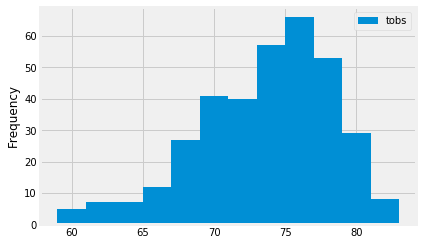

In [24]:
results = session.query(Measurement.tobs).\
filter (Measurement.station=='USC00519281').filter(Measurement.date >= prev_year).all()
results = pd.DataFrame(results, columns=['tobs'])

results.plot.hist(bins=12)
plt.savefig('Images/Temperature.png')
plt.show()

# Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip = calc_temps('2017-05-09', '2017-05-12')
my_trip

[(67.0, 74.95454545454545, 79.0)]

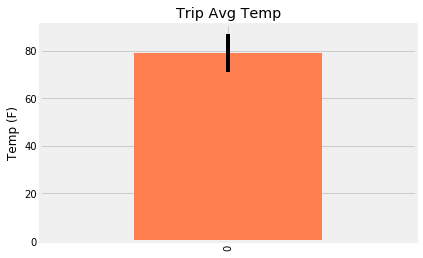

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_df = pd.DataFrame(my_trip, columns=['tmin', 'tmax', 'tavg'])
my_trip_df.plot.bar(y='tavg', yerr=(my_trip_df['tmax']-my_trip_df['tmin']), title='Trip Avg Temp', color='coral')

plt.ylabel('Temp (F)')
plt.gca().legend_.remove()

plt.savefig('Images/Trip_Average_Temperature.png')
plt.show()


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# use two tables and join 


## Optional 

In [121]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [90]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
